# RL Pricing Notebook (Model-Based, Multi-Step) for `autos.csv`

This notebook builds a model-based reinforcement learning pipeline for pricing used-car listings when true repricing trajectories are unavailable.  
We model listing disappearance as a weekly hazard process and train a tabular Q-learning policy in that simulated environment.

## Cell 0 — Config + Imports

In [ ]:
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_squared_log_error

np.random.seed(42)
random.seed(42)

# ============================================================================
# DATA & ENVIRONMENT CONFIGURATION
# ============================================================================
DATA_PATH = "data/autos.csv"
CURRENT_YEAR = 2025
TMAX = 12  # Maximum weeks to track a listing

# ============================================================================
# PRICING ACTIONS
# ============================================================================
ACTION_PCTS = np.array([-0.05, -0.03, 0.0, +0.03, +0.05], dtype=float)

# ============================================================================
# RL TRAINING HYPERPARAMETERS
# ============================================================================
ALPHA = 0.10  # Learning rate
GAMMA = 0.95  # Discount factor
HOLDING_COST = 20.0  
N_EPISODES = 20000  
N_EVAL = 500

# ============================================================================
# EXPLORATION STRATEGY (Epsilon-Greedy)
# ============================================================================
EPS_START = 1.0  # Initial exploration rate (100% random actions)
EPS_END = 0.05  # Final exploration rate (5% random actions)
EPS_DECAY = 0.995  # Decay multiplier applied each episode

# ============================================================================
# STATE DISCRETIZATION
# ============================================================================
# Price deviation delta is binned into 16 intervals across [-0.5, 0.5]
DELTA_BINS = np.linspace(-0.5, 0.5, 16)

# ============================================================================
# DATA FILTERING
# ============================================================================
MIN_MODEL_COUNT = 200  # Minimum listings per brand-model to retain

# ============================================================================
# LIGHTGBM PRICE MODEL HYPERPARAMETERS
# ============================================================================
PRICE_MODEL_PARAMS = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "num_leaves": 64,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
}

# ============================================================================
# LIGHTGBM HAZARD MODEL HYPERPARAMETERS
# ============================================================================
HAZARD_MODEL_PARAMS = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "num_leaves": 64,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "class_weight": "balanced",
    "random_state": 42,
}

USE_CALIBRATION = True 


## 1) Load + Clean Data (lightweight)

In [17]:
df = pd.read_csv(DATA_PATH, encoding='latin-1')

for dt_col in ["dateCreated", "lastSeen", "dateCrawled"]:
    if dt_col in df.columns:
        df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")

df = df.dropna(subset=["dateCreated", "lastSeen"]).copy()
df["duration_days"] = (df["lastSeen"] - df["dateCreated"]).dt.total_seconds() / 86400.0
df = df[df["duration_days"] >= 0].copy()

In [18]:
p99_price = df["price"].quantile(0.99)
df = df[(df["price"] > 0) & (df["price"] <= p99_price)].copy()

df = df[(df["yearOfRegistration"] >= 1950) & (df["yearOfRegistration"] <= 2017)].copy()
df["age_years"] = CURRENT_YEAR - df["yearOfRegistration"]
df = df[(df["age_years"] >= 0) & (df["age_years"] <= 60)].copy()

p99_km = df["kilometer"].quantile(0.99)
df = df[df["kilometer"] > 0].copy()
df["kilometer"] = df["kilometer"].clip(upper=p99_km)

p99_power = df["powerPS"].quantile(0.99)
df = df[df["powerPS"] >= 10].copy()
df["powerPS"] = df["powerPS"].clip(upper=p99_power)

cat_cols = ["brand", "model", "vehicleType", "fuelType", "gearbox", "notRepairedDamage", "seller"]
for c in cat_cols:
    if c not in df.columns:
        df[c] = "unknown"
    df[c] = df[c].fillna("unknown").astype(str)

df["month_created"] = df["dateCreated"].dt.month.astype(int)

In [19]:
df["duration_weeks"] = np.ceil(df["duration_days"] / 7.0).astype(int)
df["duration_weeks"] = df["duration_weeks"].clip(lower=1, upper=TMAX)

## 2) Safe Grouping Strategy

In [20]:
df["year_bin"] = (df["yearOfRegistration"] // 3) * 3
group_counts = df.groupby(["brand", "model"]).size().rename("cnt").reset_index()
keep_pairs = set(map(tuple, group_counts[group_counts["cnt"] >= MIN_MODEL_COUNT][["brand", "model"]].values))

def slim_model(row):
    return row["model"] if (row["brand"], row["model"]) in keep_pairs else "other"

df["model_slim"] = df.apply(slim_model, axis=1)
df["seg"] = df["brand"].astype(str) + "|" + df["model_slim"].astype(str) + "|" + df["vehicleType"].astype(str) + "|" + df["year_bin"].astype(str)
if df["seg"].nunique() > 2000:
    df["seg"] = df["brand"].astype(str) + "|" + df["vehicleType"].astype(str) + "|" + df["year_bin"].astype(str)
df["seg"] = df["seg"].fillna("unknown")

## 3) Baseline Price Model `p0(x)`

In [21]:
df = df.sort_values("dateCreated").reset_index(drop=True)
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx].copy()
valid_df = df.iloc[split_idx:].copy()

In [22]:
for part in [train_df, valid_df, df]:
    part["log_km"] = np.log1p(part["kilometer"])
    part["log_power"] = np.log1p(part["powerPS"])

price_num_cols = ["age_years", "log_km", "log_power", "month_created"]
price_cat_cols = ["brand", "vehicleType", "gearbox", "fuelType", "notRepairedDamage", "seller"]
if "model_slim" in df.columns and df["model_slim"].nunique() < 300:
    price_cat_cols.append("model_slim")

for c in price_cat_cols:
    train_df[c] = train_df[c].astype("category")
    valid_df[c] = valid_df[c].astype("category")
    df[c] = df[c].astype("category")

price_model = lgb.LGBMRegressor(**PRICE_MODEL_PARAMS)
price_model.fit(train_df[price_num_cols + price_cat_cols], np.log(train_df["price"]), categorical_feature=price_cat_cols)

pred_valid_log = price_model.predict(valid_df[price_num_cols + price_cat_cols])
rmsle = np.sqrt(mean_squared_log_error(np.exp(np.log(valid_df["price"])), np.exp(pred_valid_log)))
print("RMSLE", rmsle)

df["p0"] = np.exp(price_model.predict(df[price_num_cols + price_cat_cols]))

# Ensure valid_df has p0 column by syncing with df
valid_df["p0"] = df.loc[valid_df.index, "p0"].values

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 253390, number of used features: 10
[LightGBM] [Info] Start training from score 8.033205
RMSLE 0.5238390594204858


In [23]:
df["delta_obs"] = np.log(df["price"] / df["p0"])
df["delta_obs"] = df["delta_obs"].clip(-0.7, 0.7)

## 4) Transition Model: Weekly Hazard `h(x,t,Δ)`

In [24]:
base_cols = ["age_years","log_km","log_power","month_created","brand","vehicleType","gearbox","fuelType","notRepairedDamage","seller","seg","delta_obs","duration_weeks"]
base = df[base_cols].reset_index(drop=True).copy()
d = base["duration_weeks"].to_numpy()
idx_rep = np.repeat(np.arange(len(base)), d)
t_week = np.concatenate([np.arange(1, k + 1) for k in d])
y = (t_week == np.repeat(d, d)).astype(int)
pw = base.iloc[idx_rep].reset_index(drop=True)
pw["t_week"] = t_week
pw["y"] = y
pw = pw.rename(columns={"delta_obs": "delta"})

In [25]:
haz_num_cols = ["age_years", "log_km", "log_power", "month_created", "t_week", "delta"]
pw["t_week_sq"] = pw["t_week"] ** 2
haz_num_cols += ["t_week_sq"]
haz_cat_cols = ["brand", "vehicleType", "gearbox", "fuelType", "notRepairedDamage", "seller", "seg"]

train_mask_pw = idx_rep < split_idx
valid_mask_pw = idx_rep >= split_idx
pw_train = pw.loc[train_mask_pw].copy()
pw_valid = pw.loc[valid_mask_pw].copy()
for c in haz_cat_cols:
    pw_train[c] = pw_train[c].astype("category")
    pw_valid[c] = pw_valid[c].astype("category")

hazard_base_model = lgb.LGBMClassifier(**HAZARD_MODEL_PARAMS)
hazard_base_model.fit(pw_train[haz_num_cols + haz_cat_cols], pw_train["y"], categorical_feature=haz_cat_cols)
if USE_CALIBRATION:
    hazard_model = CalibratedClassifierCV(hazard_base_model, method="sigmoid", cv=3)
    hazard_model.fit(pw_train[haz_num_cols + haz_cat_cols], pw_train["y"])
else:
    hazard_model = hazard_base_model

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 253390, number of negative: 291818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 545208, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large

In [26]:
q = df.groupby("seg")["delta_obs"].quantile([0.05, 0.95]).unstack()
q.columns = ["delta_min", "delta_max"]
delta_bounds = {seg: (float(v["delta_min"]), float(v["delta_max"])) for seg, v in q.iterrows()}

## 5) Implement RL Environment

In [27]:
class CarPricingEnv:
    def __init__(self, listings_df, hazard_model, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=42):
        self.listings_df = listings_df.reset_index(drop=True).copy()
        self.hazard_model = hazard_model
        self.delta_bounds = delta_bounds
        self.TMAX = TMAX
        self.ACTION_PCTS = np.array(ACTION_PCTS, dtype=float)
        self.HOLDING_COST = float(HOLDING_COST)
        self.rng = np.random.default_rng(seed)
        self.seg_to_id = {s: i for i, s in enumerate(sorted(self.listings_df["seg"].unique()))}
        self.row = None
        self.t = None
        self.delta = None
        self.done = None
        self.p0_value = None

    def _delta_bucket(self, delta):
        b = np.digitize([delta], DELTA_BINS)[0] - 1
        return int(np.clip(b, 0, len(DELTA_BINS) - 2))

    def _state(self):
        return (self.seg_to_id.get(self.row["seg"], 0), int(self.t), self._delta_bucket(self.delta))

    def reset(self):
        self.row = self.listings_df.iloc[int(self.rng.integers(0, len(self.listings_df)))]
        self.t = 1
        self.delta = 0.0
        self.done = False
        # Store p0 value when resetting
        self.p0_value = float(self.row["p0"])
        return self._state()

    def step(self, action_index):
        a = float(self.ACTION_PCTS[action_index])
        delta_new = self.delta + np.log1p(a)
        dmin, dmax = self.delta_bounds.get(str(self.row["seg"]), (-0.5, 0.5))
        delta_new = float(np.clip(delta_new, dmin, dmax))

        x_full = {
            "age_years": float(self.row["age_years"]),
            "log_km": float(self.row["log_km"]),
            "log_power": float(self.row["log_power"]),
            "month_created": int(self.row["month_created"]),
            "brand": str(self.row["brand"]),
            "vehicleType": str(self.row["vehicleType"]),
            "gearbox": str(self.row["gearbox"]),
            "fuelType": str(self.row["fuelType"]),
            "notRepairedDamage": str(self.row["notRepairedDamage"]),
            "seller": str(self.row["seller"]),
            "seg": str(self.row["seg"]),
            "t_week": int(self.t),
            "delta": float(delta_new),
            "t_week_sq": int(self.t) ** 2,
        }
        X = pd.DataFrame([x_full], columns=haz_num_cols + haz_cat_cols)
        for c in haz_cat_cols:
            X[c] = X[c].astype("category")
        p_event = float(np.clip(self.hazard_model.predict_proba(X)[0, 1], 0.0, 1.0))
        event = bool(self.rng.random() < p_event)

        if event:
            # Reward = 25% of the actual selling price
            actual_price = self.p0_value * np.exp(delta_new)
            reward = float(actual_price)
            self.done = True
        else:
            reward = -self.HOLDING_COST
            self.t += 1
            self.done = self.t > self.TMAX

        self.delta = delta_new
        return self._state(), reward, self.done, {"p_event": p_event, "delta": delta_new, "event": event}

## 6) Train RL Agent (Q-learning)

In [ ]:
env_train = CarPricingEnv(valid_df, hazard_model, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=42)
n_actions = len(ACTION_PCTS)
Q = defaultdict(lambda: np.zeros(n_actions, dtype=float))

def epsilon_greedy_action(state, eps):
    return np.random.randint(n_actions) if np.random.rand() < eps else int(np.argmax(Q[state]))

eps = EPS_START
ep_returns = []
for ep in range(N_EPISODES):
    s = env_train.reset()
    total_r = 0.0
    for _ in range(TMAX):
        a = epsilon_greedy_action(s, eps)
        s_next, r, done, _ = env_train.step(a)
        Q[s][a] += ALPHA * (r + (0.0 if done else GAMMA * np.max(Q[s_next])) - Q[s][a])
        s = s_next
        total_r += r
        if done:
            break
    ep_returns.append(total_r)
    eps = max(EPS_END, eps * EPS_DECAY)

pd.Series(ep_returns).rolling(200).mean().plot(figsize=(8,3), title="Training return moving average")
plt.grid(alpha=0.3)
plt.show()

## 7) Baselines + Evaluation

In [ ]:
idx_zero = int(np.argmin(np.abs(ACTION_PCTS - 0.0)))
idx_minus3 = int(np.argmin(np.abs(ACTION_PCTS - (-0.03))))

def baseline_keep_price(s, info=None):
    return idx_zero

def baseline_drop_late(s, info=None):
    return idx_minus3 if s[1] >= 3 else idx_zero

def rl_policy(s, info=None):
    return int(np.argmax(Q[s]))

keep_price {'avg_return': 1330.8989, 'avg_weeks': 2.206, 'avg_price_ratio_cond_event': 1.0007}
drop_late {'avg_return': 1249.728, 'avg_weeks': 2.074, 'avg_price_ratio_cond_event': 0.9853}
rl_q_learning {'avg_return': 1096.1836, 'avg_weeks': 2.154, 'avg_price_ratio_cond_event': 0.8682}


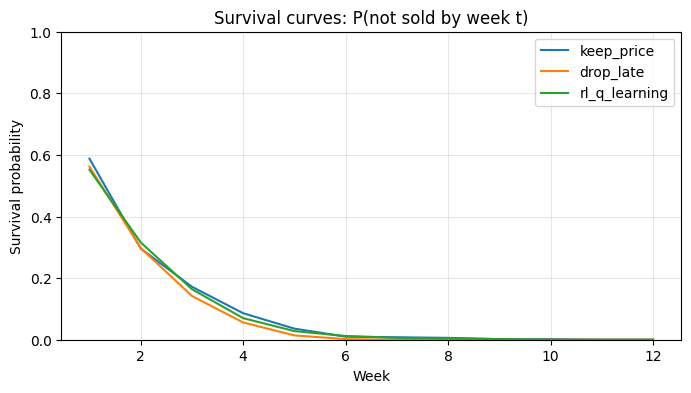

In [ ]:
env_eval = CarPricingEnv(valid_df, hazard_model, delta_bounds, TMAX, ACTION_PCTS, HOLDING_COST, seed=123)

def evaluate_policy(policy_fn, n_eval=N_EVAL):
    returns, weeks, ratio_event = [], [], []
    not_sold_by_week = np.zeros(TMAX + 1)
    for _ in range(n_eval):
        s = env_eval.reset()
        done = False
        total_r = 0.0
        step_count = 0
        last_info = None
        event = False
        while not done and step_count < TMAX:
            a = policy_fn(s, last_info)
            s, r, done, info = env_eval.step(a)
            last_info = info
            total_r += r
            step_count += 1
            event = info["event"]
        returns.append(total_r)
        weeks.append(step_count)
        if event:
            ratio_event.append(np.exp(last_info["delta"]))
        for t in range(1, TMAX + 1):
            if t < step_count or (t == step_count and not event):
                not_sold_by_week[t] += 1
    return {
        "avg_return": float(np.mean(returns)),
        "avg_weeks": float(np.mean(weeks)),
        "avg_price_ratio_cond_event": float(np.mean(ratio_event)) if ratio_event else np.nan,
        "survival": not_sold_by_week / n_eval,
        "returns": np.array(returns),
    }

results = {
    "keep_price": evaluate_policy(baseline_keep_price),
    "drop_late": evaluate_policy(baseline_drop_late),
    "rl_q_learning": evaluate_policy(rl_policy),
}
for k, v in results.items():
    print(k, {kk: round(v[kk], 4) for kk in ["avg_return", "avg_weeks", "avg_price_ratio_cond_event"]})

plt.figure(figsize=(8,4))
for k, v in results.items():
    plt.plot(np.arange(1, TMAX + 1), v["survival"][1:], label=k)
plt.title("Survival curves: P(not sold by week t)")
plt.xlabel("Week")
plt.ylabel("Survival probability")
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## 8) Notes
- Event = listing disappearance (sold/removed proxy).
- Model-based RL is used because repricing trajectories are sparse.
- Grouping is only for state abstraction + delta support bounds.
- `p0(x)` and `delta` reduce, but do not eliminate, confounding from unobserved quality.